In [1]:
# Animal classification
# https://www.kaggle.com/stpeteishii/animal-detection-by-yolo-coco-model

In [8]:
import math
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers
from tqdm import tqdm

In [23]:
# example of loading the mnist dataset
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [26]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
BATCH_SIZE = 64
img_height = 28
img_width = 28
SHUFFLE_BUFFER_SIZE = 100
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds.shuffle(SHUFFLE_BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
# Iterate all the dataset, and retrieve only the y
# Then filter only for unique
class_names = list(set(np.concatenate([y for x, y in train_ds], axis=0)))

In [28]:
for element in train_ds.take(1):
    data = element[0]
    labels = element[1]
    print("Labels:", labels)
    print("Image shape:", data.shape)

Labels: tf.Tensor(
[1 1 6 3 5 1 7 3 0 4 7 4 6 0 1 1 4 5 9 5 7 4 9 1 8 1 6 9 2 8 8 7 9 6 2 5 0
 4 5 6 6 4 1 1 1 4 9 9 7 0 6 2 4 3 9 8 1 8 0 7 0 2 4 4], shape=(64,), dtype=uint8)
Image shape: (64, 28, 28)


In [35]:
model = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(
            1.0 / 255, input_shape=(img_height, img_width, 1)
        ),
        #         layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        #         layers.experimental.preprocessing.RandomRotation(0.1),
        layers.Conv2D(128, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(len(class_names), activation="softmax"),
    ]
)
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [ ]:
model.fit(
    train_ds, validation_data=val_ds, epochs=10, batch_size=BATCH_SIZE,
)

In [83]:
loss, acc = model.evaluate(val_ds)
print("Accuracy", acc)

157/157 [==============================] - 1s 4ms/step - loss: 0.0820 - accuracy: 0.9854
Accuracy 0.9854000210762024


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

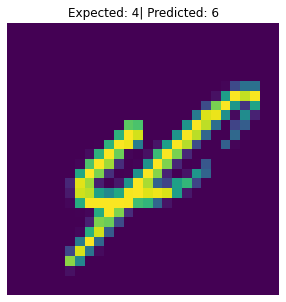

<Figure size 360x360 with 0 Axes>

In [84]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(10):

    fig = plt.figure(figsize=(5, 5))
    pred_prob = [(np.argmax(p), max(p)) for p in model.predict(images)]
    predictions = [class_names[a[0]] for a in pred_prob]
    expected = [class_names[a] for a in labels]
    not_match = [i for i in range(len(predictions)) if predictions[i] != expected[i]]
    rows = columns = int(math.ceil(len(not_match)))
    for i in range(len(not_match)):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(images[not_match[i]].numpy().astype("uint8"))
        plt.title(
            "Expected: {}| Predicted: {}".format(
                expected[not_match[i]], predictions[not_match[i]]
            )
        )
        plt.axis("off")